# Applied Data Analysis Project
**Team**: ToeStewBrr - Alexander Sternfeld, Marguerite Thery, Antoine Bonnet, Hugo Bordereaux

**Dataset**: CMU Movie Summary Corpus


In [141]:
import requests
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from nltk.tree import Tree
import xml.etree.ElementTree as ET
import itertools
import matplotlib.dates as mdates

from load_data import *
pd.options.mode.chained_assignment = None


## 1. Loading data

We first extract all files from the [MoviesSummaries dataset](http://www.cs.cmu.edu/~ark/personas/). 

`corenlp_plot_summaries.tar.gz [628 M, separate download]`: The plot summary of each movie, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv).

We extract all coreNLP files, then uncompress them to the XML format. 

Note: Extraction of CoreNLP files takes 15 minutes, while conversion takes 30 seconds. 

In [142]:
download_data()

## 2. Pre-processing data

### 2.1. Plot summaries

`plot_summaries.txt [29 M]`: Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.

In [143]:
plot_df = load_plot_df()
plot_df

,Wikipedia ID,Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...
...,...,...
42298,34808485,"The story is about Reema , a young Muslim scho..."
42299,1096473,"In 1928 Hollywood, director Leo Andreyev look..."
42300,35102018,American Luthier focuses on Randy Parsons’ tra...
42301,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se..."


In [144]:
# For Hugo: this method stems the words to their lexical root. 
# Implement Stemming using out of the box Porter algorithm
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
plot_stemmed = [[stemmer.stem(word) for word in sentence.split(" ")] for sentence in plot_df.iloc[:5].Summary]
plot_stemmed = [" ".join(sentence) for sentence in plot_stemmed]


### 2.2. Movie metadata

`movie.metadata.tsv.gz [3.4 M]`: Metadata for 81,741 movies. 

In [145]:
movie_df = load_movie_df()
movie_df

,Wikipedia ID,Freebase ID,Name,Release date,Box office revenue,Runtime,Languages,Countries,Genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama]
...,...,...,...,...,...,...,...,...,...
81736,35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English],[United States of America],[Drama]
81737,34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]"
81738,9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,[English],[United States of America],"[Satire, Comedy]"
81739,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,[Japanese],[Japan],"[Science Fiction, Japanese Movies, Adventure, ..."


### 2.3. Character metadata

`character.metadata.tsv.gz [14 M]`: Metadata for 450,669 characters aligned to the movies above. 


In [146]:
char_df = load_char_df()
char_df

,Wikipedia ID,Freebase ID,Release date,Character name,Date of birth,Gender,Height,Ethnicity,Actor name,Actor age at release,Freebase character/map ID,Freebase character ID,Freebase actor ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
450664,913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
450665,913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
450666,28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44
450667,28308153,/m/0cp05t9,1957,NaN,NaN,NaN,NaN,NaN,Roberta Paterson,NaN,/m/0g8ngmj,NaN,/m/0g8ngmm


### 2.4. Name clusters

`name.clusters.txt`: 970 unique character names used in at least two different movies, along with 2,666 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.

In [147]:
names_df = load_names_df()
names_df

,Cluster
Character name,
'Baby' Louise,"[/m/0c0lv89, /m/0h2cmv_]"
ACP Jai Dixit,"[/m/0jx7ny, /m/0220_c2]"
Abigail Chase,"[/m/02vcd9h, /m/0k14v6]"
Abraham Lincoln,"[/m/0k059l1, /m/0k89pf, /m/02tbdlx]"
Abraham Van Helsing,"[/m/0jwq7y, /m/02vc_c7, /m/0jxjq1, /m/0k4llv, ..."
...,...
Yosemite Sam,"[/m/0hynrhr, /m/0hyn6wh, /m/0hynsvw, /m/0hynzf..."
Young Jack,"[/m/03jq87t, /m/03jppd0]"
Young Jake,"[/m/0hndzk9, /m/0bwsx65]"


### 2.5. TV Tropes Clusters

`tvtropes.clusters.txt`: 72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.

In [148]:
cluster_df = load_cluster_df()
cluster_df


,Cluster,Character name,Movie,Freebase character/map ID,Actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader
...,...,...,...,...,...
496,young_gun,Morgan Earp,Tombstone,/m/0k776f,Bill Paxton
497,young_gun,Colorado Ryan,Rio Bravo,/m/0k2kqg,Ricky Nelson
498,young_gun,Tom Sawyer,The League of Extraordinary Gentlemen,/m/0k5nsh,Shane West
499,young_gun,William H. 'Billy the Kid' Bonney,Young Guns II,/m/03lrjk0,Emilio Estevez


We now join the TV tropes clusters with movie.metadata so we are able to access movie genre and filter on romance. 

In [149]:
cluster_char = cluster_df.merge(char_df, on='Freebase character/map ID')
cluster_char_movie = cluster_char.merge(movie_df, on='Freebase ID')
romance_cluster = cluster_char_movie[cluster_char_movie['Genres'].apply(lambda x: any('Roman' in genre for genre in x))]
romance_cluster.groupby(romance_cluster['Cluster']).size().sort_values(ascending=False)
romance_cluster

,Cluster,Character name_x,Movie,Freebase character/map ID,Actor,Wikipedia ID_x,Freebase ID,Release date_x,Character name_y,Date of birth,...,Freebase character ID,Freebase actor ID,Wikipedia ID_y,Name,Release date_y,Box office revenue,Runtime,Languages,Countries,Genres
12,arrogant_kungfu_guy,Johnny Lawrence,The Karate Kid,/m/0k5jyf,William Zabka,91133,/m/0mmbb,1984-06-22,Johnny Lawrence,1965-10-20,...,/m/0h5nlb8,/m/038nt1,91133,The Karate Kid,1984-06-22,90815558.0,127.0,"[Japanese, English]","[United States of America, Japan]","[Action/Adventure, Japanese Movies, Adventure,..."
13,jerk_jock,Johnny Lawrence,The Karate Kid,/m/0k5jyf,William Zabka,91133,/m/0mmbb,1984-06-22,Johnny Lawrence,1965-10-20,...,/m/0h5nlb8,/m/038nt1,91133,The Karate Kid,1984-06-22,90815558.0,127.0,"[Japanese, English]","[United States of America, Japan]","[Action/Adventure, Japanese Movies, Adventure,..."
14,eccentric_mentor,Mr. Kesuke Miyagi,The Karate Kid,/m/0k5jxz,Pat Morita,91133,/m/0mmbb,1984-06-22,Mr. Kesuke Miyagi,1932-06-28,...,/m/025rqg0,/m/01xpxv,91133,The Karate Kid,1984-06-22,90815558.0,127.0,"[Japanese, English]","[United States of America, Japan]","[Action/Adventure, Japanese Movies, Adventure,..."
15,arrogant_kungfu_guy,Jen Yu,"Crouching Tiger, Hidden Dragon",/m/0jwv09,Zhang Ziyi,5313,/m/01mgw,2000-05-16,Jen Yu,1979-02-09,...,/m/059xf46,/m/0jlv5,5313,"Crouching Tiger, Hidden Dragon",2000-05-16,213525736.0,120.0,[Standard Mandarin],"[United States of America, Hong Kong, China, T...","[Adventure, Period piece, Martial Arts Film, F..."
16,warrior_poet,Master Li Mu Bai,"Crouching Tiger, Hidden Dragon",/m/0jwt__,Chow Yun-Fat,5313,/m/01mgw,2000-05-16,Master Li Mu Bai,1955-05-18,...,/m/059xf3y,/m/0m9v7,5313,"Crouching Tiger, Hidden Dragon",2000-05-16,213525736.0,120.0,[Standard Mandarin],"[United States of America, Hong Kong, China, T...","[Adventure, Period piece, Martial Arts Film, F..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,storyteller,Wendy Darling,Peter Pan,/m/0k1vn1,Rachel Hurd-Wood,740744,/m/037cr1,2003-12-09,Wendy Darling,1990-08-17,...,/m/025tvd2,/m/059f88,740744,Peter Pan,2003-12-09,121975011.0,107.0,[English],"[United States of America, Australia, United K...","[Costume drama, Family Film, Fantasy, Adventur..."
482,the_editor,Walter Burns,His Girl Friday,/m/0jzg14,Cary Grant,74018,/m/0jsxn,1940-01-11,Walter Burns,1904-01-18,...,/m/02nwg2f,/m/09qh1,74018,His Girl Friday,1940-01-11,NaN,92.0,"[French, English]",[United States of America],"[Romantic comedy, Media Satire, Screwball come..."
490,valley_girl,Julie Richman,Valley Girl,/m/03jprhz,Deborah Foreman,2406870,/m/079xtj,1983-04-29,Julie Richman,1962-10-12,...,/m/096452v,/m/0341ht,2406870,Valley Girl,1983-04-29,17343596.0,99.0,[English],[United States of America],"[Romantic comedy, Comedy of manners, Coming of..."
491,valley_girl,Elle Woods,Legally Blonde,/m/0j_wm4,Reese Witherspoon,444267,/m/0296vv,2001-06-26,Elle Woods,1976-03-22,...,/m/0blvvf,/m/0n6f8,444267,Legally Blonde,2001-06-26,141774679.0,97.0,[English],[United States of America],"[Romantic comedy, Comedy of manners, Comedy, C..."


### 2.6. Missing values and outliers

#### 2.6.1. Identifying missing values

In [150]:
len(movie_df)

81741

In [151]:
# Missing values
movie_cols = ['Wikipedia ID', 'Freebase ID', 'Name', 'Release date', 
'Box office revenue', 'Runtime', 'Languages', 'Countries', 'Genres']
for column in movie_cols[3:]:
    number_missing = movie_df[column].isna().sum()
    print(f'{column}: {number_missing}/{len(movie_df)} ({round(100*number_missing/movie_df.shape[0],2)}%) missing values')


Release date: 6902/81741 (8.44%) missing values
Box office revenue: 73340/81741 (89.72%) missing values
Runtime: 20450/81741 (25.02%) missing values
Languages: 13866/81741 (16.96%) missing values
Countries: 8154/81741 (9.98%) missing values
Genres: 2294/81741 (2.81%) missing values


#### 2.6.2. Outliers
- We note that there is one movie with a release date in the year 1010, we manually correct this to the date 2010
- There are many movies with very short runtimes (under 5 minutes). We manually verified a sample of these movies, and have found that the runtimes are correct.
- There are over a hundred movies with runtimes over 5 hours. We have found that most of these data points correspond to series, where the runtime is the sum of the episode lengths.
- One movie has a runtime of over a million minutes ('Zero tolerance'). This lengths is manually corrected to 88 minutes.

In [180]:
# Isolate the year from the release date
getYear = lambda x: x[slice(0,4)] if type(x) == str else x
movie_df['Release date'] = movie_df['Release date'].apply(getYear)

# Identify suspicious movie with release date 1010, manually correct
outlier_release_date = movie_df[movie_df['Release date'].apply(lambda x: int(x.split('-')[0]) < 1850 if type(x)==str else False)]
movie_df['Release date'][movie_df['Wikipedia ID']==29666067] = '2010'

# Identify suspicious movies with long runtimes
movie_df[movie_df['Runtime'] > 300]
movie_df['Runtime'][movie_df['Wikipedia ID']==10815585] = '88'


## 3. Exploratory Data Analysis


### 3.1. Analysing romantic genres

One notices that there are several types of romantic movies: romantic comedy, romance film, romantic drama. 

In [181]:
romance_genres = ['Romantic comedy', 'Romance Film', 'Romantic drama', 'Romantic fantasy', 'Romantic thriller']
is_romantic = lambda i: lambda x: any(y in romance_genres[i] for y in x) if type(x) == list else False
is_not_romantic = lambda i: lambda x: not any(y in romance_genres[i] for y in x) if type(x) == list else False
romance_movies = movie_df[movie_df['Genres'].apply(is_romantic(slice(0, 5)))]
non_romance_movies = movie_df[movie_df['Genres'].apply(is_not_romantic(slice(0, 5)))]

In [182]:
#Organize by category
romantic_comedy = romance_movies.loc[movie_df['Genres'].apply(is_romantic(0))]
romantic_film = romance_movies.loc[movie_df['Genres'].apply(is_romantic(1))]
romantic_drama = romance_movies.loc[movie_df['Genres'].apply(is_romantic(2))]
romantic_fantasy = romance_movies.loc[movie_df['Genres'].apply(is_romantic(3))]
romantic_thriller = romance_movies.loc[movie_df['Genres'].apply(is_romantic(4))]
print('Romance:' , romance_movies.shape[0])
print('Romantic comedies: ', romantic_comedy.shape[0], '\nRomantic films: ', romantic_film.shape[0], '\nRomantic drama: ', romantic_drama.shape[0], '\nRomantic fantasy: ', romantic_fantasy.shape[0], '\nRomantic thriller: ', romantic_thriller.shape[0])
print('Total number of films: ', movie_df.shape[0])

Romance: 11131
Romantic comedies:  2680 
Romantic films:  10234 
Romantic drama:  3372 
Romantic fantasy:  72 
Romantic thriller:  1
Total number of films:  81743


### 3.2. Romantic movies runtime

TypeError: '<' not supported between instances of 'str' and 'int'

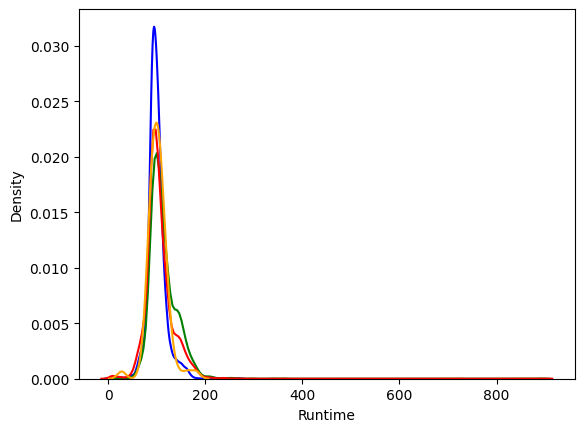

In [183]:
ax = sns.kdeplot(romantic_comedy['Runtime'], color='blue')
ax = sns.kdeplot(romantic_drama['Runtime'], color='green')
ax = sns.kdeplot(romantic_film['Runtime'], color='red')
ax = sns.kdeplot(romantic_fantasy['Runtime'], color='orange')
ax = sns.kdeplot(non_romance_movies[non_romance_movies['Runtime'] < 200]['Runtime'], color = 'purple')
ax.set_xlim(0, 200)
ax.legend(['Romantic comedy', 'Romantic drama', 'Romance Film', 'Romantic fantasy', 'Non romantic movies'])
plt.title('Movie runtime distribution by genre')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Density')
plt.show()

### 3.3. Romantic movies box office revenue

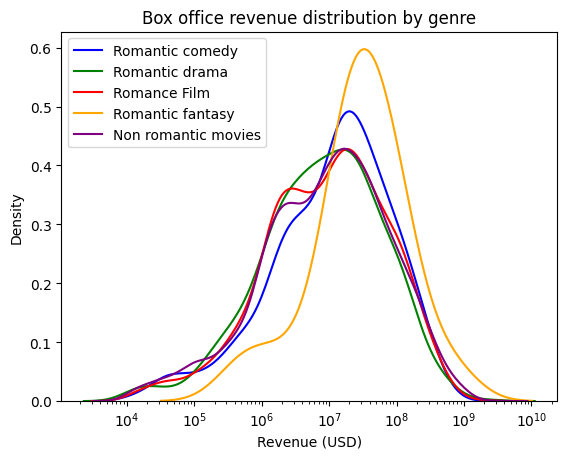

In [ ]:
ax = sns.kdeplot(romantic_comedy['Box office revenue'], log_scale=True, color='blue')
ax = sns.kdeplot(romantic_drama['Box office revenue'], log_scale=True, color='green')
ax = sns.kdeplot(romantic_film['Box office revenue'], log_scale=True, color='red')
ax = sns.kdeplot(romantic_fantasy['Box office revenue'], log_scale=True, color='orange')
ax = sns.kdeplot(non_romance_movies['Box office revenue'], log_scale=True, color='purple')
ax.legend(['Romantic comedy', 'Romantic drama', 'Romance Film', 'Romantic fantasy', 'Non romantic movies'])
plt.title('Box office revenue distribution by genre')
plt.xlabel('Revenue (USD)')
plt.ylabel('Density')
plt.show()

### 3.4. Romantic movies countries

In [184]:
get_countries = lambda x: len(x) if type(x) == list else np.nan
romantic_comedy['number_countries'] = romantic_comedy['Countries'].apply(get_countries)
romantic_fantasy['number_countries'] = romantic_fantasy['Countries'].apply(get_countries)
romantic_film['number_countries'] = romantic_film['Countries'].apply(get_countries)
romantic_drama['number_countries'] = romantic_drama['Countries'].apply(get_countries)

combined_numb_countries = pd.DataFrame({
    'Romantic comedy': romantic_comedy['number_countries'], 
    'Romance Film': romantic_film['number_countries'], 
    'Romantic drama': romantic_drama['number_countries'], 
    'Romantic fantasy': romantic_fantasy['number_countries']})

print('Percentage romantic comedy movie countries > 1: ', round(romantic_comedy[romantic_comedy['number_countries']> 1].shape[0]/romantic_comedy.shape[0], 2), '%')
print('Other countries can be added in code...')

Percentage romantic comedy movie countries > 1:  0.14 %
Other countries can be added in code...


### 3.5. Movie languages

In [185]:
#Get languages whole movie set
movies_language = movie_df[movie_df['Languages'].notnull()]
languages=movies_language['Languages'].sum()
values, counts = np.unique(languages, return_counts=True)
print('5 most common languages in movies are: ')
print(values[counts.argsort()[-5:][::-1]])

#Get languages romantic movies overall
romance_movies_lang = romance_movies[romance_movies['Languages'].notnull()]
languages_romance = romance_movies_lang.Languages.sum()
values, counts = np.unique(languages_romance, return_counts=True)
print('\n5 most common languages in romantic movies: ')
print(values[counts.argsort()[-5:][::-1]])


rom_com_known = romantic_comedy[romantic_comedy['Languages'].notnull()]
languages_romcom = rom_com_known.Languages.sum()
values, counts = np.unique(languages_romcom, return_counts=True)
print('\n5 most common languages in romantic comedies: ')
print(values[counts.argsort()[-5:][::-1]])

5 most common languages in movies are: 
['English' 'Hindi' 'Spanish' 'French' 'Silent film']

5 most common languages in romantic movies: 
['English' 'Hindi' 'French' 'Tamil' 'Spanish']

5 most common languages in romantic comedies: 
['English' 'French' 'Hindi' 'Spanish' 'Italian']


### 3.6. Evolution over time

#### 3.6.1 Box office revenue over time

In [359]:
year_box_office = non_romance_movies[['Release date', 'Box office revenue']].dropna()
year_box_office_romance = romance_movies[['Release date', 'Box office revenue']].dropna()
year_box_office['Release date'] = pd.to_datetime(year_box_office['Release date'])
year_box_office_romance['Release date'] = pd.to_datetime(year_box_office_romance['Release date'])

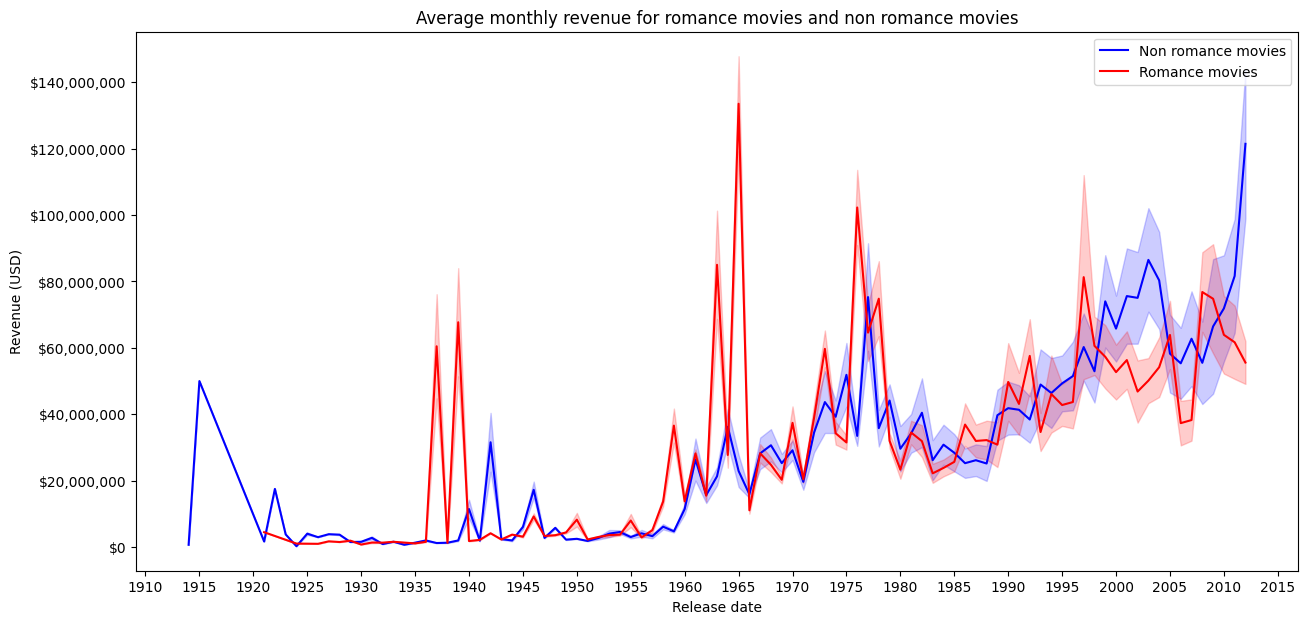

In [330]:
import matplotlib
# Get yearly box office revenue for romantic and non-romantic movies
year_box_office = non_romance_movies[['Release date', 'Box office revenue']].dropna()
year_box_office_romance = romance_movies[['Release date', 'Box office revenue']].dropna()
year_box_office['Release date'] = pd.to_datetime(year_box_office['Release date'])
year_box_office_romance['Release date'] = pd.to_datetime(year_box_office_romance['Release date'])

# TODO: Fix the standard deviations for the box office revenue
total_mean = year_box_office.groupby('Release date').mean().iloc[1:]
romance_mean = year_box_office_romance.groupby('Release date').mean().iloc[1:]
total_std = year_box_office.groupby('Release date').std().replace(np.nan, 0).iloc[1:]/10
romance_std = year_box_office_romance.groupby('Release date').std().replace(np.nan, 0).iloc[1:]/10


# Plot average monthly revenue for romance movies and non romance movies
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(total_mean.index, total_mean['Box office revenue'], color='blue', label='Non romance movies')
ax.plot(romance_mean.index, romance_mean['Box office revenue'], color='red', label='Romance movies')
ax.fill_between(total_mean.index, total_mean['Box office revenue'] - total_std['Box office revenue'], total_mean['Box office revenue'] + total_std['Box office revenue'], color='blue', alpha=0.2)
ax.fill_between(romance_mean.index, romance_mean['Box office revenue'] - romance_std['Box office revenue'], romance_mean['Box office revenue'] + romance_std['Box office revenue'], color='red', alpha=0.2)
years = mdates.YearLocator(5)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('${x:,.0f}'))
ax.set_xlabel('Release date')
ax.set_ylabel('Revenue (USD)')
ax.set_title('Average monthly revenue for romance movies and non romance movies')
ax.legend()
plt.show()


### 3.6.2. Evolution of runtime

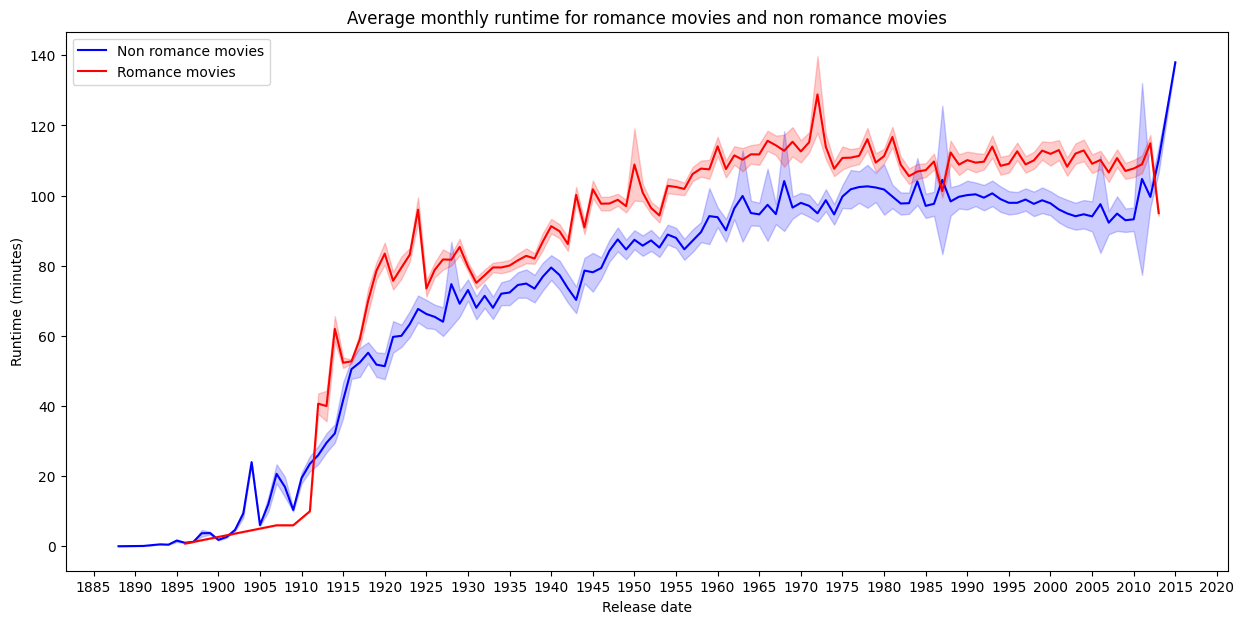

In [415]:
import matplotlib

# Get yearly runtime for romantic and non-romantic movies
year_runtime = non_romance_movies[['Release date', 'Runtime']].dropna()
year_runtime_romance = romance_movies[['Release date', 'Runtime']].dropna()
year_runtime['Runtime'] = year_runtime['Runtime'].astype(float)
year_runtime_romance['Runtime'] = year_runtime_romance['Runtime'].astype(float)

# TODO: Fix the standard deviations for the runtime
total_runtime_mean = year_runtime.groupby('Release date').mean()
romance_runtime_mean = year_runtime_romance.groupby('Release date').mean()
total_runtime_std = year_runtime.groupby('Release date').std().replace(np.nan, 0)/10
romance_runtime_std = year_runtime_romance.groupby('Release date').std().replace(np.nan, 0)/10

# Convert release date of mean and std to datetime
total_runtime_mean.index = pd.to_datetime(total_runtime_mean.index)
romance_runtime_mean.index = pd.to_datetime(romance_runtime_mean.index)
total_runtime_std.index = pd.to_datetime(total_runtime_std.index)
romance_runtime_std.index = pd.to_datetime(romance_runtime_std.index)


# Plot average monthly runtime for romance movies and non romance movies
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(total_runtime_mean.index, total_runtime_mean['Runtime'], color='blue', label='Non romance movies')
ax.plot(romance_runtime_mean.index, romance_runtime_mean['Runtime'], color='red', label='Romance movies')
ax.fill_between(total_runtime_mean.index, total_runtime_mean['Runtime'] - total_runtime_std['Runtime'], total_runtime_mean['Runtime'] + total_runtime_std['Runtime'], color='blue', alpha=0.2)
ax.fill_between(romance_runtime_mean.index, romance_runtime_mean['Runtime'] - romance_runtime_std['Runtime'], romance_runtime_mean['Runtime'] + romance_runtime_std['Runtime'], color='red', alpha=0.2)
years = mdates.YearLocator(5)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xlabel('Release date')
ax.set_ylabel('Runtime (minutes)')
ax.set_title('Average monthly runtime for romance movies and non romance movies')
ax.legend()
plt.show()